In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc

import torch
from pipeline import AnomalyDetectionPipeline
import preprocessing as prep
import machine_learning as ml

%matplotlib inline
plt.style.use('seaborn-v0_8-darkgrid')

In [2]:
# Parameters
SEQ_LENGTH = 25
BATCH_SIZE = 128
EPOCHS = 5
HIDDEN_DIM = 64
LR = 1e-3
NROWS = 40_000

In [3]:
data = 'data/TOTF.PA-book/2015-01-02-TOTF.PA-book.csv.gz'
lobster_ob = "data/LOBSTER/AMZN_2012-06-21_34200000_57600000_orderbook_10.csv"
lobster_msg = "data/LOBSTER/AMZN_2012-06-21_34200000_57600000_message_10.csv"

In [4]:
# Initialize Pipeline
pipeline = AnomalyDetectionPipeline(seq_length=SEQ_LENGTH, batch_size=BATCH_SIZE)

# Load Data
try:
    df_lobster = prep.load_lobster_data(orderbook_path=lobster_ob, message_path=lobster_msg, levels=10, nrows=NROWS)
    pipeline.raw_df = df_lobster
except Exception as e:
    print(f"Error loading data: {e}")

# pipeline.load_data(data, nrows=NROWS)

# Engineer Features
selected_features = ['base', 'tao', 'hawkes', 'poutre', 'ofi']
pipeline.engineer_features(feature_sets=selected_features)

# Preprocess Data
pipeline.scale_and_sequence(method='box-cox', train_split=0.7)

Pipeline initialized on device: cuda
Loading LOBSTER data from data/LOBSTER/AMZN_2012-06-21_34200000_57600000_orderbook_10.csv...
Successfully loaded 40000 LOBSTER rows.
Engineering features: ['base', 'tao', 'hawkes', 'poutre', 'ofi']...
Feature Engineering complete. Total features: 129
Preprocessing with method: box-cox...
Dropping 12 constant/zero-variance features: ['Hawkes_L_ask_beta100_Eta1.0', 'Hawkes_L_bid_beta100_Eta1.0', 'Hawkes_L_bid_beta1000_Eta1.0', 'Hawkes_L_ask_beta1000_Eta1.0', 'Hawkes_L_bid_beta1000_Eta10.0', 'Hawkes_L_ask_beta100_Eta10.0', 'Hawkes_L_ask_beta10_Eta1.0', 'Hawkes_L_bid_beta10_Eta10.0', 'Hawkes_L_ask_beta1000_Eta10.0', 'Hawkes_L_bid_beta100_Eta10.0', 'Hawkes_L_bid_beta10_Eta1.0', 'Hawkes_L_ask_beta10_Eta10.0']
Data split: Train (27982, 25, 117), Test (11993, 25, 117)


In [5]:
# Train PRAE Model
pipeline.train_model(
    model_type='prae', 
    epochs=EPOCHS, 
    lr=LR,
    hidden_dim=HIDDEN_DIM
)

Initializing Probabilistic Robust Autoencoder (PRAE)...
Auto-tuned lambda (Mean Energy Heuristic): 1.111415
Training PRAE (lambda=1.111415)...
Epoch 1/5 - Total Loss: -0.295746 | Rec Loss: 0.541400 | Reg Loss: -0.837146
Epoch 2/5 - Total Loss: -0.439239 | Rec Loss: 0.402288 | Reg Loss: -0.841527
Epoch 3/5 - Total Loss: -0.498820 | Rec Loss: 0.345309 | Reg Loss: -0.844129
Epoch 4/5 - Total Loss: -0.592208 | Rec Loss: 0.258774 | Reg Loss: -0.850982
Epoch 5/5 - Total Loss: -0.650686 | Rec Loss: 0.207267 | Reg Loss: -0.857953


In [6]:
results, cm = pipeline.evaluate()

print("Performance Results:")
print(results)

Evaluating model...
Performance Results:
{'AUROC': 1.0, 'AUPRC': 1.0, 'F4_Score': 0.9992795106554002}


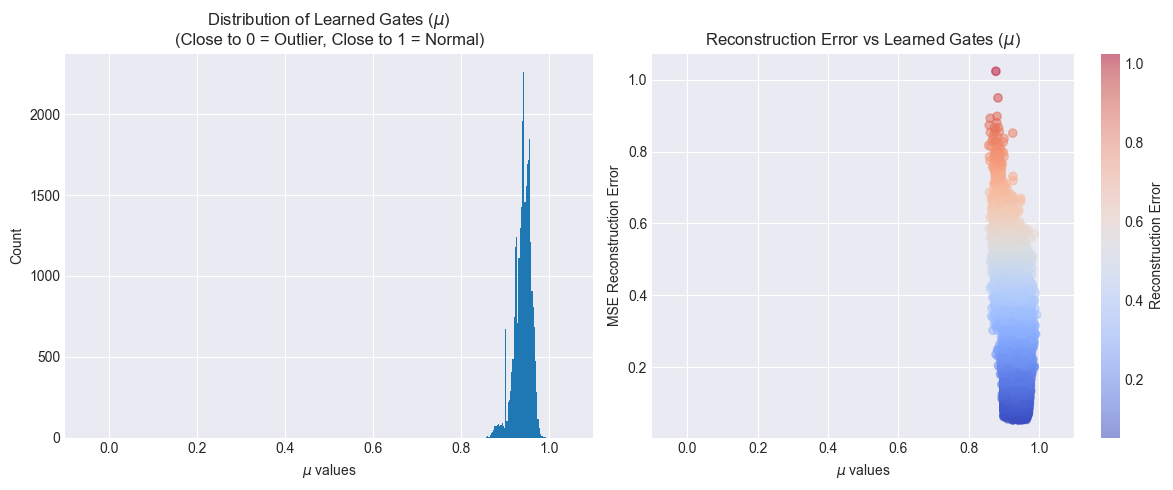

In [9]:
mu_values = pipeline.model.get_outlier_scores()

# Reconstruction error for the training set
pipeline.model.eval()
train_loader = pipeline._get_dataloader(pipeline.X_train, shuffle=False)
rec_errors = []

with torch.no_grad():
    for batch in train_loader:
        inputs = batch[0].to(pipeline.device)
        reconstructed, _ = pipeline.model(inputs, training=False)
        err = torch.mean((inputs - reconstructed) ** 2, dim=(1, 2))
        rec_errors.append(err.cpu().numpy())

rec_errors = np.concatenate(rec_errors)

# Plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(mu_values, bins=50)
plt.title('Distribution of Learned Gates ($\\mu$)\n(Close to 0 = Outlier, Close to 1 = Normal)')
plt.xlabel('$\\mu$ values')
plt.ylabel('Count')
plt.xlim(-0.1, 1.1)

plt.subplot(1, 2, 2)
sc = plt.scatter(mu_values, rec_errors, alpha=0.5, c=rec_errors, cmap='coolwarm')
plt.colorbar(sc, label='Reconstruction Error')
plt.title('Reconstruction Error vs Learned Gates ($\\mu$)')
plt.xlabel('$\\mu$ values')
plt.ylabel('MSE Reconstruction Error')
plt.xlim(-0.1, 1.1)

plt.grid(True)
plt.tight_layout()
plt.show()

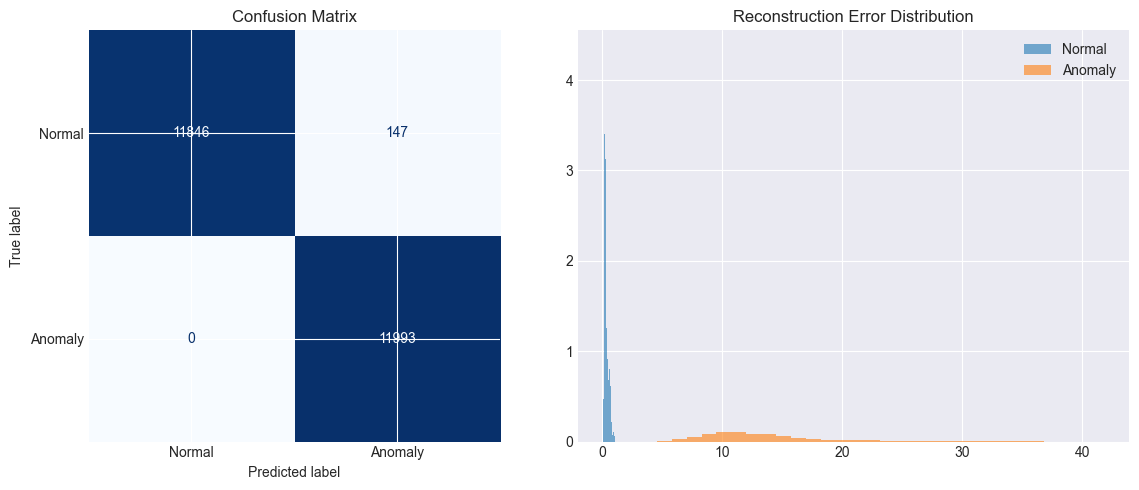

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Anomaly'])
disp.plot(ax=ax[0], cmap='Blues', colorbar=False)
ax[0].set_title('Confusion Matrix')

# Anomaly Score Distribution
_, scores, preds = pipeline.evaluate_prae()
mid = len(scores) // 2
normal_scores = scores[:mid]
anomaly_scores = scores[mid:]

ax[1].hist(normal_scores, bins=30, alpha=0.6, label='Normal', density=True)
ax[1].hist(anomaly_scores, bins=30, alpha=0.6, label='Anomaly', density=True)
ax[1].set_title('Reconstruction Error Distribution')
ax[1].legend()

plt.tight_layout()
plt.show()